# Stock Trading Strategy using Machine Learning (Linear Regression, KNN and Random Forest) - A comparision study 




## Introduction:
The goal of this project is to develop a stock trading strategy using the predictions obtained from a learning algorithm. The developed learner predicts the change in stock price over the next five trading days using Linear Regression, Random Forest and KNN. Bollinger Bands, Momentum, Volatility and Relative State Index (RSI) are the input features and the prediction is for the stock price after five trading days. Analysis was done on IBM,SINE_FAST, SINE_SLOW data. Based on the predictions made, the system is expected to suggest a position of 100 shares long, 100 share short or no action. The process was started with a cash of $10,000.


### <font color =blue>Operation 1: Data collection and pruning</font>
1. Read data from .csv file obtained from yahoo finance. 
2. The files downloaded were chosen to have data for an additional month before and beyond the start and end dates respectively
3. Adj. Close data column was selected for our current analysis.
4. Forward and backward fill was performed for missing data
5. Adj. Close data was plotted for our understanding


                  IBM
Date                 
2007-11-30  76.883553
2007-12-03  77.358650
2007-12-04  77.943428
2007-12-05  79.061798
2007-12-06  80.187523


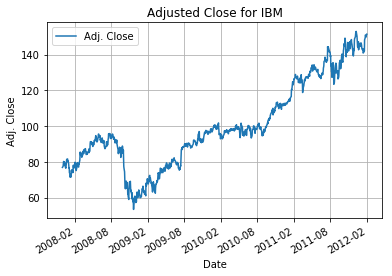

In [868]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd

sd = dt.datetime(2007,11,30) 
ed = dt.datetime(2012,1,31)
# Change the file here to IBM or SINE_Fast or any other file for analysis
syms=['IBM'] 
dates = pd.date_range(sd, ed)
dfAdj = pd.DataFrame(index=dates)
dfAdj = pd.read_csv(syms[0] + '.csv', index_col="Date", parse_dates=True, usecols=['Date', 'Adj Close'],na_values=['NaN'])    # Reading files from the data/xxx.csv. Also replacing missing values with NANs
dfAdj.head()
dfAdj = dfAdj.rename(columns={'Adj Close': syms[0]})     # Renaming the Adj Close column to the symbol
# Forward Fill / Back Fill
dfAdj=dfAdj.fillna(method='ffill')
dfAdj=dfAdj.fillna(method='bfill')
dfAdj = dfAdj.dropna()
print(dfAdj.head())



pl1 = dfAdj.plot(y=syms[0],label='Adj. Close',title='Adjusted Close for '+syms[0],fontsize=10)
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()
plt.show()


### <font color =blue>Operation 2: Feature Generation and Selection</font>
#### <font color =green>2a. Bollinger Bands</font>
Bollinger Bands is a technical analysis tool with two standard deviations sandwiching the Simple Moving Average (SMA) of a stock price. SMA is computed for a 20 day window along with the standard deviation for the same window. This band has three lines. 
1. The middle one for SMA values
2. The top and bottom ones are SMA +/- 2 standard deviations for the same moving window.
Typically, the average of first 20 days of data is considered for the 21st day average and the next days average is from day 2 to day 21 and so on. 

    - $ BU =SMA(Price,w) + 2* \sigma[Price,w]$
    - $ BL =SMA(Price,w) - 2* \sigma[Price,w]$
    - $ \sigma [Price,w]->$ Standard Deviation of the data in the window w
    - $ SMA(Price,w) ->$ Simple Moving Average
    
Further we normalize these values to bring the feature on the same scale as others. (Also called the 
[% B indicator](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_band_perce))
For the current work, additional one month data prior to the training window was considered inorder to accommodate a moving window for 20 days. Otherwise, around 20 data points are lost.

                   IBM      MVA_20     StdA_20     StdB_20    Std_20  \
Date                                                                   
2007-11-30   76.883553         NaN         NaN         NaN       NaN   
2007-12-03   77.358650         NaN         NaN         NaN       NaN   
2007-12-04   77.943428         NaN         NaN         NaN       NaN   
2007-12-05   79.061798         NaN         NaN         NaN       NaN   
2007-12-06   80.187523         NaN         NaN         NaN       NaN   
2007-12-07   79.573509         NaN         NaN         NaN       NaN   
2007-12-10   79.960922         NaN         NaN         NaN       NaN   
2007-12-11   78.206573         NaN         NaN         NaN       NaN   
2007-12-12   79.288437         NaN         NaN         NaN       NaN   
2007-12-13   79.076439         NaN         NaN         NaN       NaN   
2007-12-14   77.314781         NaN         NaN         NaN       NaN   
2007-12-17   76.408394         NaN         NaN         NaN      

C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


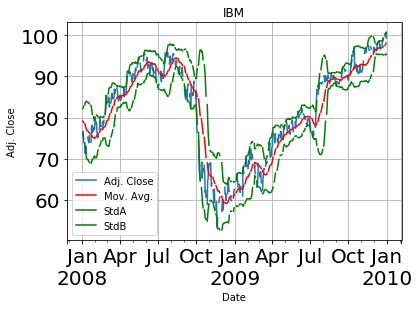

In [869]:
bolBand=pd.DataFrame()
wndwSize=20
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['MVA_20']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_20']=bolBand['MVA_20']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_20']=bolBand['MVA_20']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_20']=dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['BolNorm_20']=(bolBand[syms[0]]-bolBand['MVA_20'])/(2*bolBand['Std_20'])
#print(bolBand['BolNorm_20'].min())
#print(bolBand['BolNorm_20'].max())


wndwSize=5

bolBand['MVA_5']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_5']=bolBand['MVA_5']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_5']=bolBand['MVA_5']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_5']=dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['BolNorm_5']=(bolBand[syms[0]]-bolBand['MVA_5'])/(2*bolBand['Std_5'])


print(bolBand)

mastData=bolBand
# We are reducing bolBand for visualizationin graphs
dfRange=pd.date_range(start='2007-12-31',end='2009-12-31',closed=None)

bolBand=bolBand.loc[dfRange]#:dt.datetime(2008,1,31)
print(bolBand.head())
ax=plt.figure(1)
ax=plt.gca()
bolBand.plot(y=syms[0],label='Adj. Close',title=syms[0],fontsize=20,ax=ax)
bolBand.plot(y='MVA_20',label='Mov. Avg.',title=syms[0],fontsize=20,color='red',ax=ax)
bolBand.plot(y='StdA_20',label='StdA',title=syms[0],fontsize=20,color='green',ax=ax)
bolBand.plot(y='StdB_20',label='StdB',title=syms[0],fontsize=20,color='green',ax=ax)



plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()


#### <font color =green> 2b. Momentum </font>
Momentum indicates stock price strength. It indicates how fast or slow the stock prices change. It is just a difference of stock values over a window.
- Simply given as $ Momentum = P - P_n$
- where, P is current price and $P_n$ is the closing price before 'n' trading days.

In the current process, we considered momentum across various windows, expecting to use them as features for training our ML algorithms.
From the correlation values obtained below in results, momentum with 20 window was found to have a higher value, hence we plan to use a 20 point window for our ML training.

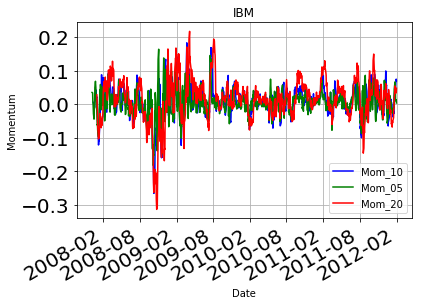

In [870]:
#print(bolBand['Date'])

mNSize=10;
mNSize1=5;
mNSize2=20;
momentum=mastData.reset_index()
momentum['Mom_10']=np.nan
momentum['Mom_05']=np.nan
momentum['Mom_20']=np.nan
momentum['Mom_01']=np.nan
for x in range(mNSize,momentum[syms[0]].count()):
    momentum.at[x,'Mom_10']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize,[syms[0]]])-1
    
for x in range(mNSize1,momentum[syms[0]].count()):
    momentum.at[x,'Mom_05']= (momentum.loc[x,[syms[0]]]-momentum.loc[x-mNSize1,[syms[0]]])/ (momentum.loc[x-mNSize1,[syms[0]]])

for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_20']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize2,[syms[0]]])-1
    
for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_01']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-1,[syms[0]]])-1
#momentum=momentum.set_index('Date')


ax1=plt.figure(2)
ax1=plt.gca()


momentum=momentum.set_index('Date')
momentum.plot(y='Mom_10',label='Mom_10',title=syms[0],fontsize=20,color='blue',ax=ax1)
momentum.plot(y='Mom_05',label='Mom_05',title=syms[0],fontsize=20,color='green',ax=ax1)
momentum.plot(y='Mom_20',label='Mom_20',title=syms[0],fontsize=20,color='red',ax=ax1)

#mastData['Mom_20']=momentum['Mom_20']
mastData[['Mom_20','Mom_10','Mom_05']]=momentum[['Mom_20','Mom_10','Mom_05']]
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid()


#### <font color =green>2c. Relative Strength Index</font>
Relative Strength Index (RSI)is a momentum oscilator measuring the change of price moments and speed. This is valued between 0 and 100 (Scaled down for our current learning)
The first step is the calculation of Relative Strength. Given by the ratio of average gain to average loss over a window period
***    
$ RS =(Average Gain_{14}/Average Loss_{14}) $ 
***
$ RSI = 100-[100/(1+RS)]$

[% RSI indicator](https://www.investopedia.com/terms/r/rsi.asp)


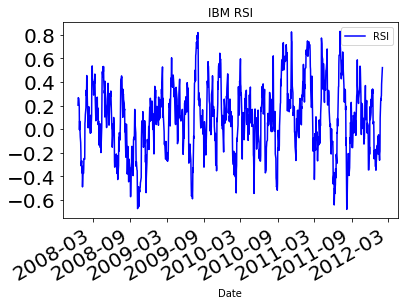

In [871]:
dfDummy=mastData
dfDummy=dfDummy.reset_index()
dfDummy=dfDummy[['Date',syms[0]]]
dfDummy['SD']=dfDummy[syms[0]].diff()
for x in range(1,dfDummy[syms[0]].count()):
    if dfDummy.loc[x,'SD']>=0:
        dfDummy.at[x,'Profits']=dfDummy.loc[x,'SD']
        dfDummy.at[x,'Loss']=0
    elif dfDummy.loc[x,'SD']<0:
        
        dfDummy.at[x,'Profits']=0
        dfDummy.at[x,'Loss']=abs(dfDummy.loc[x,'SD'])

dfDummy['ProfitAvg_14']=dfDummy['Profits'].rolling(window=14).sum()/14
dfDummy['LossAvg_14']=dfDummy['Loss'].rolling(window=14).sum()/14
dfDummy['RS_14']=dfDummy['ProfitAvg_14']/dfDummy['LossAvg_14']
dfDummy['RSI']=2*(1-1/(1+dfDummy['RS_14']))-1

axRSI=plt.figure(2)
axRSI=plt.gca()
dfDummy=dfDummy.set_index('Date')
dfDummy.plot(y='RSI',label='RSI',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
mastData['RSI_14']=dfDummy['RSI']
mastData['RS_14']=dfDummy['RS_14']
#dfDummy.plot(y=syms[0],label='IBM',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
#print(dfDummy)



#### <font color =green>2d. Adjusting Y values</font>
Further, change in Y values over a 5 day window was computed and adjust for today's data point.
After the % change was computed we also looked at pearson correlation with the various momentum windows.

                  IBM  MVA_20  StdA_20  StdB_20  Std_20  BolNorm_20     MVA_5  \
Date                                                                            
2007-11-30  76.883553     NaN      NaN      NaN     NaN         NaN       NaN   
2007-12-03  77.358650     NaN      NaN      NaN     NaN         NaN       NaN   
2007-12-04  77.943428     NaN      NaN      NaN     NaN         NaN       NaN   
2007-12-05  79.061798     NaN      NaN      NaN     NaN         NaN       NaN   
2007-12-06  80.187523     NaN      NaN      NaN     NaN         NaN  78.28699   

               StdA_5     StdB_5     Std_5  BolNorm_5  Mom_20  Mom_10  Mom_05  \
Date                                                                            
2007-11-30        NaN        NaN       NaN        NaN     NaN     NaN     NaN   
2007-12-03        NaN        NaN       NaN        NaN     NaN     NaN     NaN   
2007-12-04        NaN        NaN       NaN        NaN     NaN     NaN     NaN   
2007-12-05        NaN      

,Mom_05,Mom_10,Mom_20,Y_5
Mom_05,1.000000,0.637144,0.484314,-0.175356
Mom_10,0.637144,1.000000,0.686725,-0.104821
Mom_20,0.484314,0.686725,1.000000,-0.105475
Y_5,-0.175356,-0.104821,-0.105475,1.000000


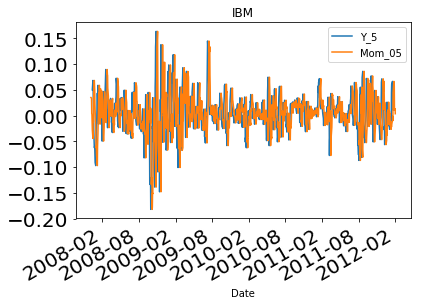

In [872]:
daysAhead=5;


mastData['Y_5']=np.nan
mastData=mastData.reset_index()
for x in range(mNSize,mastData[syms[0]].count()-daysAhead-1):
    mastData.at[x,'Y_5']= (mastData.loc[x+daysAhead,[syms[0]]])/ (mastData.loc[x,[syms[0]]])-1
ax2=plt.figure()
ax2=plt.gca()
mastData=mastData.set_index('Date')


print(mastData.head())
mastData.plot(y='Y_5',label='Y_5',title=syms[0],fontsize=20,ax=ax2)
mastData.plot(y='Mom_05',label='Mom_05',ax=ax2)
dfCorr=mastData[['Mom_05','Mom_10','Mom_20','Y_5']]
dfCorr.corr(method='pearson')

### <font color =blue>Operation 3: Machine Learning</font>
#### <font color =green>3a. Data Separation</font>
Here we separate the data for training and testing. Our training data is between the dates 01/01/2007 and 12/31/2009.
Testing data is between 12/31/2009 and  12/31/2011
We selected the features 
$BolNorm_{20},Mom_{05},RSI_{14},Std_{20},BolNorm_{5},Std_5$

In [873]:
dfMLDataTrain=mastData



dfRangeTrain=pd.date_range(start='2007-1-1',end='2009-12-31',closed=None)
dfMLDataTrain=dfMLDataTrain.loc[dfRangeTrain]

dfMLDataTrain=dfMLDataTrain.reset_index()

dfMLDataTrain=dfMLDataTrain.drop(columns='index')


dfMLDataTrain=dfMLDataTrain.replace([np.inf, -np.inf], np.nan)
dfMLDataTrain=dfMLDataTrain.fillna(method='bfill')
dfMLDataTrain=dfMLDataTrain.fillna(method='ffill')

dfMLDataTrain=dfMLDataTrain.dropna()
dfTrainingX=dfMLDataTrain[['BolNorm_20','Mom_05','RSI_14','Std_20','BolNorm_5','Std_5']]
dfTrainingY=dfMLDataTrain['Y_5']
print(dfMLDataTrain.tail())
#print("Training Data")
#print(dfTrainingX.head())


# Testing Data

dfMLDataTest=mastData



dfRangeTest=pd.date_range(start='2009-12-31',end='2011-12-31',closed=None)
dfMLDataTest=dfMLDataTest.loc[dfRangeTest]

dfMLDataTest=dfMLDataTest.reset_index()
dfMLDataTest=dfMLDataTest.drop(columns='index')

dfMLDataTest=dfMLDataTest.replace([np.inf, -np.inf], np.nan)
dfMLDataTest=dfMLDataTest.fillna(method='bfill')
dfMLDataTest=dfMLDataTest.fillna(method='ffill')

dfMLDataTest=dfMLDataTest.dropna()
dfTestingX=dfMLDataTest[['BolNorm_20','Mom_05','RSI_14','Std_20','BolNorm_5','Std_5']]
dfTestingY=dfMLDataTest['Y_5']







print('Training Features Shape:', dfTrainingX.shape)
print('Training Labels Shape:', dfTrainingY.shape)
print('Testing Features Shape:', dfTestingX.shape)
print('Testing Labels Shape:', dfTestingY.shape)


             IBM     MVA_20     StdA_20    StdB_20    Std_20  BolNorm_20  \
1091  100.372673  97.537343   99.816051  95.258635  1.139354    1.244271   
1092  100.372673  97.537343   99.816051  95.258635  1.139354    1.244271   
1093  100.023689  97.745961  100.135995  95.355928  1.195017    0.953011   
1094  100.569916  97.921581  100.597680  95.245482  1.338049    0.989625   
1095   99.303009  98.061546  100.718151  95.404940  1.328303    0.467312   

          MVA_5      StdA_5     StdB_5     Std_5  BolNorm_5    Mom_20  \
1091  98.841780  100.857792  96.825768  1.008006   0.759367  0.052586   
1092  98.841780  100.857792  96.825768  1.008006   0.759367  0.052586   
1093  99.327296  100.979834  97.674759  0.826269   0.421408  0.043530   
1094  99.727846  101.429313  98.026378  0.850734   0.494908  0.036189   
1095  99.864397  101.189346  98.539447  0.662475  -0.423705  0.029007   

        Mom_10    Mom_05    RSI_14     RS_14       Y_5  
1091  0.020281  0.034399  0.468446  2.762553 -0

C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


#### <font color =green>3b. Regression Learning</font>

False
False
-0.015955993941155724
The coefficient for BolNorm_20 is -0.015955993941155724
The coefficient for Mom_05 is -0.19272997220102153
The coefficient for RSI_14 is 0.02145878867463257
The coefficient for Std_20 is -0.0052126242257833156
The coefficient for BolNorm_5 is 0.030390876802483466
The coefficient for Std_5 is -0.005016269444044079
The intercept for our model is 0.032157878829464415
Training MSE is 0.032945794789518236
        Y_5
0  0.003200
1  0.021188
2  0.021188
3  0.021188
4  0.021188


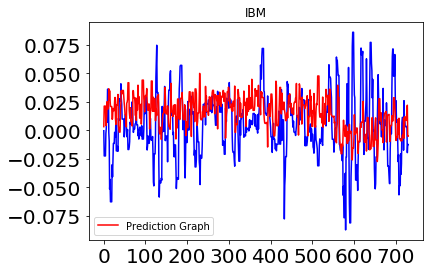

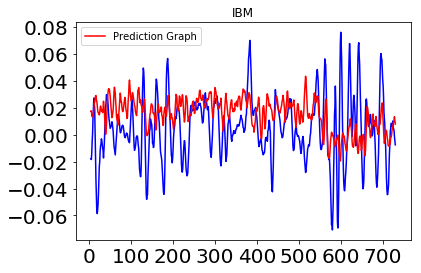

In [874]:
regression_model=LinearRegression()
print(dfTrainingY.isnull().values.any())
print(dfTrainingY.isnull().values.any())
regression_model.fit(dfTrainingX,dfTrainingY)

print(regression_model.coef_[0])
for idx, col_name in enumerate(dfTrainingX.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))
intercept=regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

regression_model.score(dfTrainingX,dfTrainingY)

from sklearn.metrics import mean_squared_error
predictY=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(predictY,dfTestingY)
regression_model_mse
import math
print("Training MSE is {}".format(math.sqrt(regression_model_mse)))

dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=5).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=5).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)
dfErrors=pd.DataFrame()
dfErrorDummy=pd.DataFrame()
dfPredictions=pd.DataFrame()

dfPredictions['Linear Regression']=dfPredictY['Y_5']
dfErrorDummy['err']=error
dfErrors.at[1,'Linear Regression']=regression_model_mse

#### <font color =green>3c. Random Forest</font>

Testing MSE is 0.035433707855549404
Mean Absolute Error: 0.02
-46.26833326858642
Accuracy 146.27 %.
        Y_5
0 -0.004116
1 -0.002761
2 -0.002761
3 -0.002761
4 -0.002761


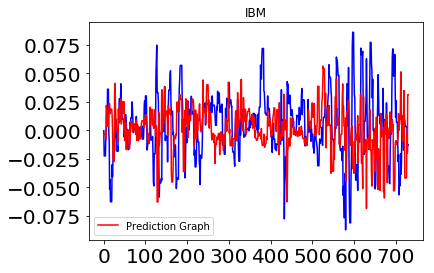

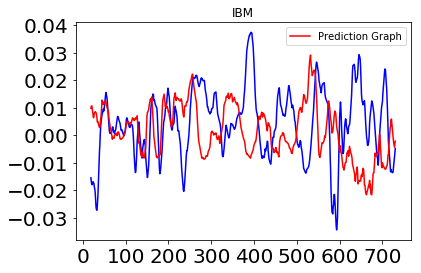

In [875]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dfTrainingX,dfTrainingY)
predictY=rf.predict(dfTestingX)


randomForest_model_mse=mean_squared_error(predictY,dfTestingY)
randomForest_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(randomForest_model_mse)))
errors = abs(predictions - dfTestingY)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = 100 * (errors / dfTestingY)

accuracy=100-np.mean(mape)
print(np.mean(mape))
print('Accuracy',round(accuracy,2),'%.')


dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=20).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=20).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)
dfPredictions['Random Forest']=dfPredictY['Y_5']
dfErrorDummy['err']=error
dfErrors.at[1,'Random Forest']=randomForest_model_mse

#### <font color =green>3d. KNN</font>


        Y_5
0  0.014424
1  0.005776
2  0.005776
3  0.005776
4  0.005776
   Linear Regression  Random Forest       KNN
1           0.001085       0.001256  0.030337
Empty DataFrame
Columns: [err]
Index: []


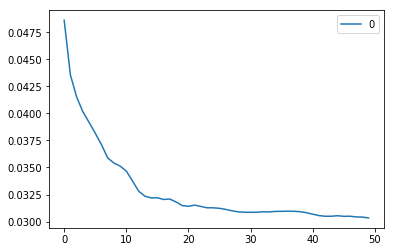

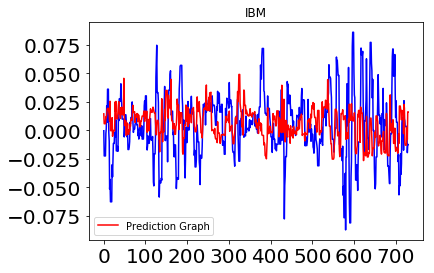

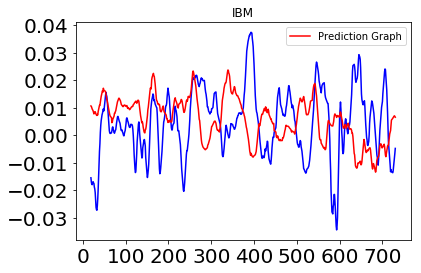

In [876]:
from sklearn import neighbors
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(dfTrainingX, dfTrainingY)  #fit the model
    predictY=model.predict(dfTestingX) #make prediction on test set
    error = sqrt(mean_squared_error(dfTestingY,predictY)) #calculate rmse
    rmse_val.append(error) #store rmse values
    #print('RMSE value for k= ' , K , 'is:', error)
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()


dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=20).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=20).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)

dfErrors.at[1,'KNN']=error
dfPredictions['KNN']=dfPredictY['Y_5']
print(dfErrors)
print(dfErrorDummy)

### <font color =blue>Operation 4: Purchase Strategy</font>
Our purchase strategy is based on the percentage change prediction in stock values. We set this to $+-2%$. Our Buy and sell positions are 100 shares and we start with a current value of 10000 $. Here we analyse the performance of the algorithms interms of the profits generated over a 2 year test duration. We find the random forest to be the best performer in most of the cases.

Final Cash on Hand:
   Linear Regression  Random Forest          KNN
1         10295.0232    368994.1001  233120.7716
MSE:
   Linear Regression  Random Forest       KNN
1           0.001085       0.001256  0.030337


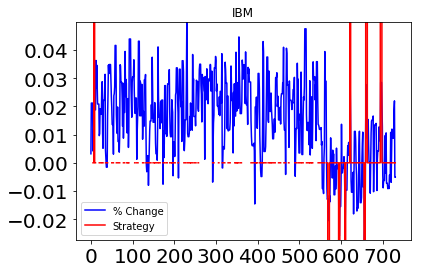

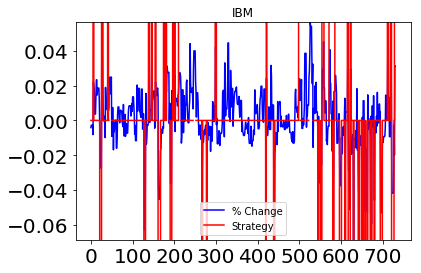

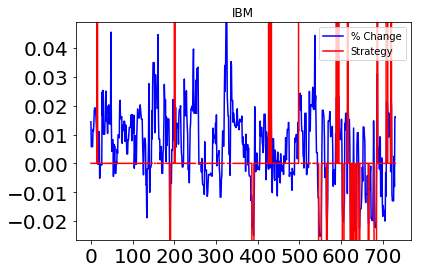

In [877]:
buyThresh=0.02
sellThresh=-0.02
currentvalue=10000;
buyPosition=100;
sellPosition=100;

# Linear Regression

for x in range(dfPredictions['Linear Regression'].count()):
    if(dfPredictions.loc[x,'Linear Regression'])>buyThresh and currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]>0:
        dfPredictions.at[x,'LR Strategy']=1
        currentvalue=currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]
      #  print('buy')
    elif (dfPredictions.loc[x,'Linear Regression'])<sellThresh:
        dfPredictions.at[x,'LR Strategy']=-1
        currentvalue=currentvalue+sellPosition*dfMLDataTest.loc[x,syms[0]]
       # print('sell')
    elif (dfPredictions.loc[x,'Linear Regression']>=sellThresh and dfPredictions.loc[x,'Linear Regression']<=buyThresh):
        dfPredictions.at[x,'LR Strategy']=0
        #print('nothing')

axStratLin=plt.figure()
axStratLin=plt.gca()


dfPredictions.plot(y='Linear Regression',label='% Change',title=syms[0],fontsize=20,color='blue',ax=axStratLin)

dfPredictions.plot(y='LR Strategy',label='Strategy',title=syms[0],fontsize=20,color='red',ax=axStratLin)
plt.ylim(dfPredictions['Linear Regression'].min(),dfPredictions['Linear Regression'].max())


dfFinalValue=pd.DataFrame()
dfFinalValue.at[1,'Linear Regression']=currentvalue



# Random Forest
currentvalue=10000;
for x in range(dfPredictions['Random Forest'].count()):
    if(dfPredictions.loc[x,'Random Forest'])>buyThresh and currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]>0:
        dfPredictions.at[x,'RF Strategy']=1
        currentvalue=currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]
      #  print('buy')
    elif (dfPredictions.loc[x,'Random Forest'])<sellThresh:
        dfPredictions.at[x,'RF Strategy']=-1
        currentvalue=currentvalue+sellPosition*dfMLDataTest.loc[x,syms[0]]
       # print('sell')
    elif (dfPredictions.loc[x,'Random Forest']>=sellThresh and dfPredictions.loc[x,'Random Forest']<=buyThresh):
        dfPredictions.at[x,'RF Strategy']=0
        #print('nothing')

axStratLin=plt.figure()
axStratLin=plt.gca()


dfPredictions.plot(y='Random Forest',label='% Change',title=syms[0],fontsize=20,color='blue',ax=axStratLin)

dfPredictions.plot(y='RF Strategy',label='Strategy',title=syms[0],fontsize=20,color='red',ax=axStratLin)
plt.ylim(dfPredictions['Random Forest'].min(),dfPredictions['Random Forest'].max())




dfFinalValue.at[1,'Random Forest']=currentvalue



# KNN
currentvalue=10000
for x in range(dfPredictions['KNN'].count()):
    if(dfPredictions.loc[x,'KNN'])>buyThresh and currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]>0:
        dfPredictions.at[x,'KNN Strategy']=1
        currentvalue=currentvalue-buyPosition*dfMLDataTest.loc[x,syms[0]]
      #  print('buy')
    elif (dfPredictions.loc[x,'KNN'])<sellThresh:
        dfPredictions.at[x,'KNN Strategy']=-1
        currentvalue=currentvalue+sellPosition*dfMLDataTest.loc[x,syms[0]]
       # print('sell')
    elif (dfPredictions.loc[x,'KNN']>=sellThresh and dfPredictions.loc[x,'KNN']<=buyThresh):
        dfPredictions.at[x,'KNN Strategy']=0
        #print('nothing')

axStratLin=plt.figure()
axStratLin=plt.gca()


dfPredictions.plot(y='KNN',label='% Change',title=syms[0],fontsize=20,color='blue',ax=axStratLin)

dfPredictions.plot(y='KNN Strategy',label='Strategy',title=syms[0],fontsize=20,color='red',ax=axStratLin)
plt.ylim(dfPredictions['KNN'].min(),dfPredictions['KNN'].max())



dfFinalValue.at[1,'KNN']=currentvalue
print('Final Cash on Hand:')
print(dfFinalValue)
print('MSE:')
print(dfErrors)